### Cat State Simulation ###
This notebook uses pulses to simulate Van der Pol oscillator on single ion. The readout is using precise operator instead of pulse sequences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, destroy, mesolve, qeye, Options, displace, wigner, enr_thermal_dm, thermal_dm, coherent_dm, hinton, ptrace
import qutip
import random

In [42]:
# Parameters in the ion trap
nu = 0.52*2*np.pi    # MHz vib freq
N = 20               # Boson number cutoff
eta=0.134            # Lamb-Dicke parameter
Rabi_freq = 0.047*np.pi*2    # MHz


In [43]:
# pauli operators on spin
sigma_3 = basis(2, 0) * basis(2, 0).dag() - basis(2, 1) * basis(2, 1).dag()
sigma_2 = -1.0j*basis(2, 0) * basis(2, 1).dag()+1.0j* basis(2, 1) * basis(2, 0).dag()
sigma_1 = basis(2, 0) * basis(2, 1).dag() + basis(2, 1) * basis(2, 0).dag()
sigma_0 = qeye(2)

#print(sigma_3, sigma_2, sigma_1)

sigma_p = (sigma_1+ 1.0j* sigma_2)/2
sigma_m = (sigma_1- 1.0j* sigma_2)/2

#print(sigma_3)

project_dn=basis(2, 1) * basis(2, 1).dag()

project_up=basis(2, 0) * basis(2, 0).dag()

psi_x_up=(basis(2,1)+basis(2,0)).unit()
psi_x_dn=(basis(2,1)-basis(2,0)).unit()

project_x_dn=psi_x_dn* psi_x_dn.dag()
project_x_up=psi_x_up * psi_x_up.dag()

project_dn_full=tensor(project_dn,qeye(N))
project_up_full=tensor(project_up,qeye(N))

project_x_dn_full=tensor(project_x_dn,qeye(N))
project_x_up_full=tensor(project_x_up,qeye(N))

def Rotate(theta:float, phi:float):
    return np.cos(theta/2)*sigma_0-1.0j*np.sin(theta/2.0)*(np.cos(phi)*sigma_1+np.sin(phi)*sigma_2)

# boson operators
a = destroy(N)
a_dag = a.dag()



print(sigma_1*sigma_2-sigma_2*sigma_1 - 2.0j*sigma_3) #sanity check

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]


### Lamb-Dicke Regime ###
Reference: 1. Leibfried et al.: Quantum dynamics of single trapped ions

$H_{LD}=\frac{\hbar}{2}\Omega_0\sigma_+\exp(i\eta(\hat{a}e^{-i\nu t}+\hat{a}^\dagger e^{i\nu t}))e^{i(\phi-\delta t)}$

First order blue sideband: $\frac{i\hbar}{2}\Omega_0\eta(\sigma_+a^\dagger e^{i\phi}-\sigma_-ae^{-i\phi})$

First order red sideband: $\frac{i\hbar}{2}\Omega_0\eta(\sigma_+a e^{i\phi}-\sigma_-a^\dagger e^{-i\phi})$

Second order red sideband: $-\frac{\hbar}{4}\Omega_0\eta^2(\sigma_+a^2e^{i\phi}+\sigma_-{a^\dagger}^2e^{-i\phi})$

Let's set $\hbar=1$ in the simulation


In [44]:
# blue sideband pulse
def Ham_BSB(att:float, phi:float):
    return 1.0j/2*Rabi_freq*eta*(tensor(sigma_p,a_dag)*np.exp(1.0j*phi)-tensor(sigma_m,a)*np.exp(-1.0j*phi)) * att

# red sideband pulse
def Ham_RSB(att:float,phi:float):
    return 1.0j/2*Rabi_freq*eta*(tensor(sigma_p,a)*np.exp(1.0j*phi)-tensor(sigma_m,a_dag)*np.exp(-1.0j*phi))*att

# 2 order red sideband pulse
def Ham_2RSB(att:float,phi:float):
    return -1/4*Rabi_freq*eta**2*(tensor(sigma_p,a*a)*np.exp(1.0j*phi)+tensor(sigma_m,a_dag*a_dag)*np.exp(-1.0j*phi))*att

#carrier
def Ham_Carrier(Rabi_freq:float, phi:float):
    return Rabi_freq/2.0*(tensor(sigma_p,qeye(N))*np.exp(1.0j*phi)+tensor(sigma_m,qeye(N))*np.exp(-1.0j*phi))


def Ham_Bic_SB(att:float, phi_rsb:float, phi_bsb:float):
    return (Ham_BSB(att,phi_bsb)+Ham_RSB(att,phi_rsb))

def RF_drive():
    return 

def Get_Wigner(state_dm, max_occ, num_point):
    state_dm_tmp=state_dm/state_dm.tr()
    xvec = np.linspace(-max_occ,max_occ,num_point)
    return wigner(state_dm_tmp, xvec, xvec)


In [56]:
#simulation setting 
psi_post_cooling=thermal_dm(N, 0)

# psi_post_cooling=qutip.ket2dm(basis(N,0))
rho0 = tensor(qutip.ket2dm(basis(2,1)), psi_post_cooling) 

#store evolution results
res_sz=np.array([])
res_n=np.array([])

#save the wave function in time evolution
option=Options(store_final_state=True)

# print("sx: ", qutip.expect(rho0,tensor(sigma_1,qeye(N))))
# print("sy: ", qutip.expect(rho0,tensor(sigma_2,qeye(N))))
# print("sz: ", qutip.expect(rho0,tensor(sigma_3,qeye(N))))

# ham_bic=  Ham_Carrier(Rabi_freq, -np.pi/2) #x basis 
# tlist1 = np.linspace(0, np.pi/Rabi_freq/2, 100)
# result = mesolve(ham_bic, rho0, tlist1, [], [tensor(sigma_3, qeye(N)), tensor(sigma_0, a_dag*a)], options=option)
# rho0 = result.final_state

print("sx: ", qutip.expect(rho0,tensor(sigma_1,qeye(N))))
print("sy: ", qutip.expect(rho0,tensor(sigma_2,qeye(N))))
print("sz: ", qutip.expect(rho0,tensor(sigma_3,qeye(N))))


# blue sideband pulse
def Ham_BSB(att:float, phi:float):
    return 1.0j/2*Rabi_freq*eta*(tensor(sigma_p,a_dag)*np.exp(1.0j*phi)-tensor(sigma_m,a)*np.exp(-1.0j*phi)) * att

# red sideband pulse
def Ham_RSB(att:float,phi:float):
    return 1.0j/2*Rabi_freq*eta*(tensor(sigma_p,a)*np.exp(1.0j*phi)-tensor(sigma_m,a_dag)*np.exp(-1.0j*phi))*att


phi_drive=np.pi/2
ham_bic= (Ham_BSB(1.0,-np.pi/2+phi_drive)+Ham_RSB(1.0, -np.pi/2-phi_drive))

tlist1 = np.linspace(0, 000, 10)
result = mesolve(ham_bic, rho0, tlist1, [], [tensor(sigma_3, qeye(N)), tensor(sigma_0, a_dag*a)], options=option)
rho0 = result.final_state

print("sx: ", qutip.expect(rho0,tensor(sigma_1,qeye(N))))
print("sy: ", qutip.expect(rho0,tensor(sigma_2,qeye(N))))
print("sz: ", qutip.expect(rho0,tensor(sigma_3,qeye(N))))

#repump 854 to ground state
tlist1 = np.linspace(0, 10, 200)
c_opr=[tensor(sigma_m,qeye(N))]
result = mesolve(ham_bic*0, rho0, tlist1, [c_opr], [], options=option)
rho0 = result.final_state

print(qutip.expect(rho0,tensor(sigma_3,qeye(N))))

sx:  0.0
sy:  0.0
sz:  -1.0
sx:  0.0
sy:  0.0
sz:  -1.0
-1.0


### calculate the wigner function with wavefunction ##

2.1459059447066114e-05
0.9999785409405529
current occ:  1.594967549635041
current occ:  1.594930383540296
current sz:  -0.999957081881106


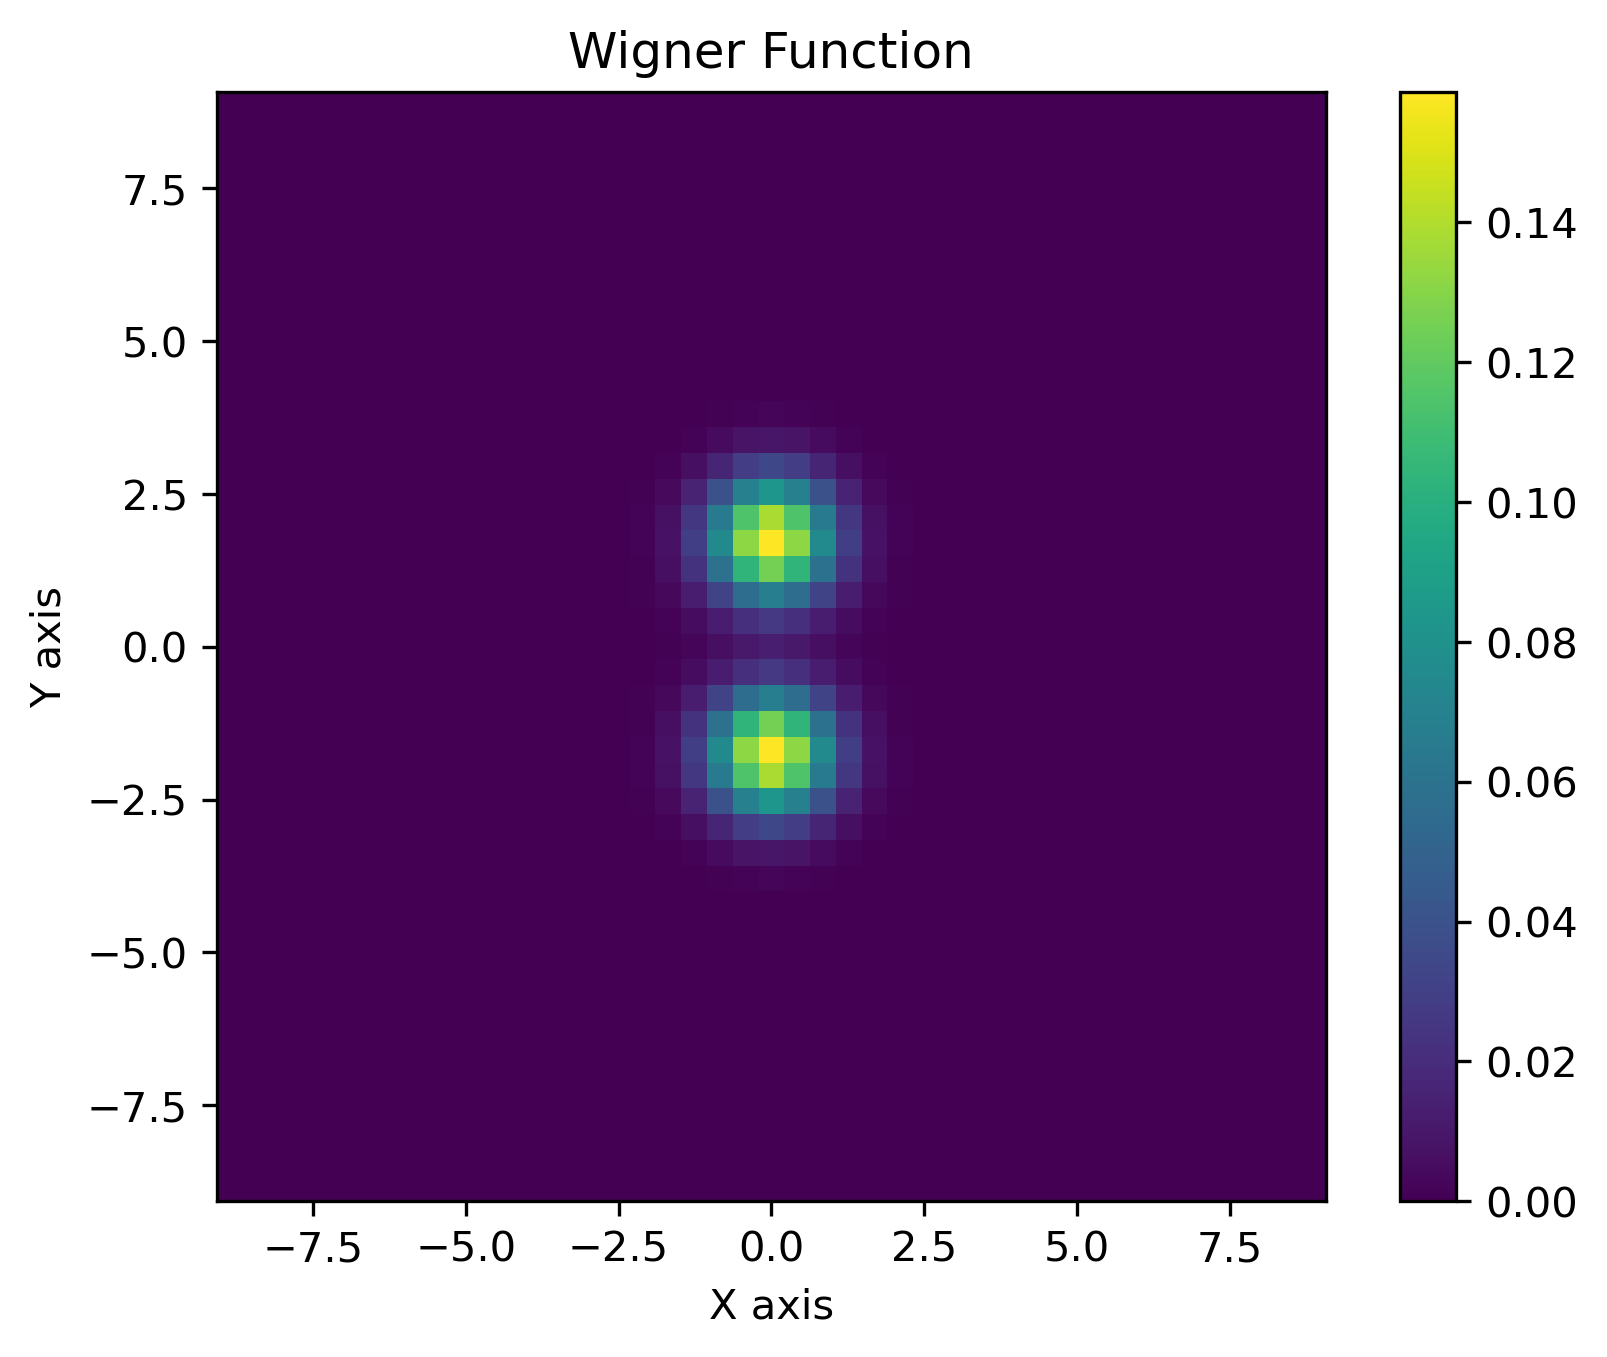

In [24]:
point_range=9.07
point_num=43


# alpha_p=displace(N, eta*Rabi_freq*40*np.exp(-1.0j*np.pi/2*0))*basis(N,0)
# alpha_m=displace(N, -eta*Rabi_freq*40*np.exp(-1.0j*np.pi/2*0))*basis(N,0)
# state=1.0/2.0*(tensor(alpha_p, alpha_p.dag())+tensor(alpha_m,alpha_m.dag()))

wig1=Get_Wigner(ptrace(project_dn_full*rho0*project_dn_full.dag(),[1]), point_range, point_num)
#Get_Wigner(state, point_range, point_num)
#Get_Wigner(ptrace(project_dn_full*rho0*project_dn_full.dag(),[1]), point_range, point_num)
#wig2=Get_Wigner(ptrace(project_x_dn_full*rho1*project_x_dn_full.dag(),[1]), point_range, point_num)

print((project_up_full*rho0*project_up_full.dag()).tr())
print((project_dn_full*rho0*project_dn_full.dag()).tr())

#wig=Get_Wigner(ptrace(rho0,[1]), point_range, point_num)


print('current occ: ', qutip.expect(tensor(sigma_0,a_dag*a),rho0))
print('current occ: ', qutip.expect(tensor(sigma_0,a_dag*a),project_dn_full*rho0*project_dn_full.dag()))
print('current sz: ' , qutip.expect(tensor(sigma_3,qeye(N)),rho0))

# Create a figure with 2 subplots
fig=plt.figure(dpi=300)

# Plot the first image
plt.imshow(np.abs(wig1), cmap='viridis',extent=[-point_range, point_range, -point_range, point_range])
plt.title('Wigner Function')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.colorbar()  # Add a colorbar to the first subplot

# Show the plot
# plt.tight_layout()  # Adjust layout to fit elements

### 1D scan with bichromatic light ###

In [57]:
def Measure_1D_Scan(state_dm, theta:float, phase=np.pi/4, num_beta=20, beta_range=10):

    option=Options(store_final_state=True)

    #rotate the state
    ham_carrier=Ham_Carrier(Rabi_freq, np.pi/2) #sigma_x
    result = mesolve(ham_carrier, state_dm, [0,theta/Rabi_freq], [], [], options=option)
    state_here = result.final_state

    #normalize density matrix
    state_here=state_here/state_here.tr()
    
    beta_time=np.linspace(0, beta_range/eta/Rabi_freq,num_beta)

    res=np.zeros(np.shape(beta_time))

    for i in range(len(res)):
        if(np.abs(beta_time[i])<1e-5): 
            res[i]=qutip.expect(state_here, tensor(sigma_3, qeye(N)))
            continue
         
        tlist=np.linspace(0, beta_time[i], 5)

        ham_bic= (Ham_BSB(1.0,-phase)+Ham_RSB(1.0,phase))

        result = mesolve(ham_bic, state_here, tlist, [], [], options=option)

        state_tmp = result.final_state

        state_tmp=state_tmp/state_tmp.tr()

        res[i]=qutip.expect(state_tmp, tensor(sigma_3, qeye(N)))
    return beta_time, res

99.99999999999999


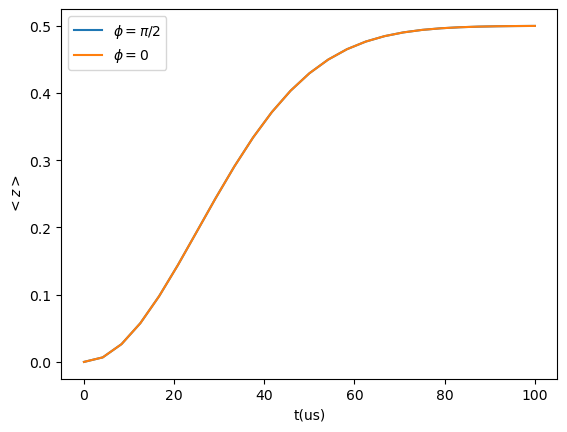

In [60]:
#the range of points to be measured
num_beta=25
beta_time= 100
beta_range=beta_time*eta*Rabi_freq

print(beta_range/eta/Rabi_freq)

# real & imag part ( we only calculate the dn spin part )
wig_1D_time, wig_1D_0=Measure_1D_Scan(rho0, 0, 0, num_beta, beta_range)
wig_1D_time, wig_1D_pi=Measure_1D_Scan(rho0, 0, np.pi/2, num_beta, beta_range)

plt.plot(wig_1D_time, np.real(wig_1D_0)/2+1/2, label='$\\phi=\\pi/2$')
plt.plot(wig_1D_time, np.real(wig_1D_pi)/2+1/2, label='$\\phi=0$')
plt.xlabel('t(us)')
plt.ylabel('$<z>$')
plt.legend()
# wigner_beta_2=(Measure_Wigner(rho0, np.pi/2, num_beta, beta_range)+1)/2

### calculate wigner function with bichromatic light ###

In [46]:
def Measure_Wigner(state_dm, theta:float, num_beta=20, beta_range=10):

    option=Options(store_final_state=True)

    #rotate the state
    ham_carrier=Ham_Carrier(Rabi_freq, np.pi/2) #sigma_x
    result = mesolve(ham_carrier, state_dm, [0,theta/Rabi_freq], [], [], options=option)
    state_here = result.final_state

    #normalize density matrix
    state_here=state_here/state_here.tr()

    #beta sampling
    beta=np.linspace(-beta_range,beta_range,num_beta).reshape((num_beta,1))+1.0j*np.linspace(-beta_range,beta_range,num_beta).reshape((1,num_beta))

    beta_time=np.zeros(beta.shape[0]*beta.shape[1],dtype=float)
    beta_phase=np.zeros(beta.shape[0]*beta.shape[1],dtype=float)

    idx=0
    for i in range(beta.shape[0]):
        for j in range(beta.shape[1]):
            #beta_time[i][j]=np.abs(beta[i][j])/eta/Rabi_freq #beta/2 here
            #beta_phase[i][j]=np.angle(beta[i][j])
            beta_time[idx]=np.abs(beta[i][j])/eta/Rabi_freq
            beta_phase[idx]=(np.angle(beta[i][j]))-np.pi/2
            idx+=1

    res=np.zeros(np.shape(beta_time))

    for i in range(len(res)):
        if(np.abs(beta_time[i])<1e-5): 
            res[i]=qutip.expect(state_here, tensor(sigma_3, qeye(N)))
            continue
         
        tlist=np.linspace(0,beta_time[i], 5)

        ham_bic= (Ham_BSB(1.0,-beta_phase[i])+Ham_RSB(1.0,beta_phase[i]))

        result = mesolve(ham_bic, state_here, tlist, [], [], options=option)

        state_tmp = result.final_state

        state_tmp=state_tmp/state_tmp.tr()

        res[i]=qutip.expect(state_tmp, tensor(sigma_3, qeye(N)))
    
    res=res.reshape(np.shape(beta))

    return res

In [47]:
#the range of points to be measured
num_beta=15
beta_time=60
beta_range=beta_time*eta*Rabi_freq

print(beta_range/eta/Rabi_freq)

# real & imag part ( we only calculate the dn spin part )
wigner_beta_1=(Measure_Wigner(rho0, 0, num_beta, beta_range)+1)/2
# wigner_beta_2=(Measure_Wigner(rho0, np.pi/2, num_beta, beta_range)+1)/2

60.00000000000001


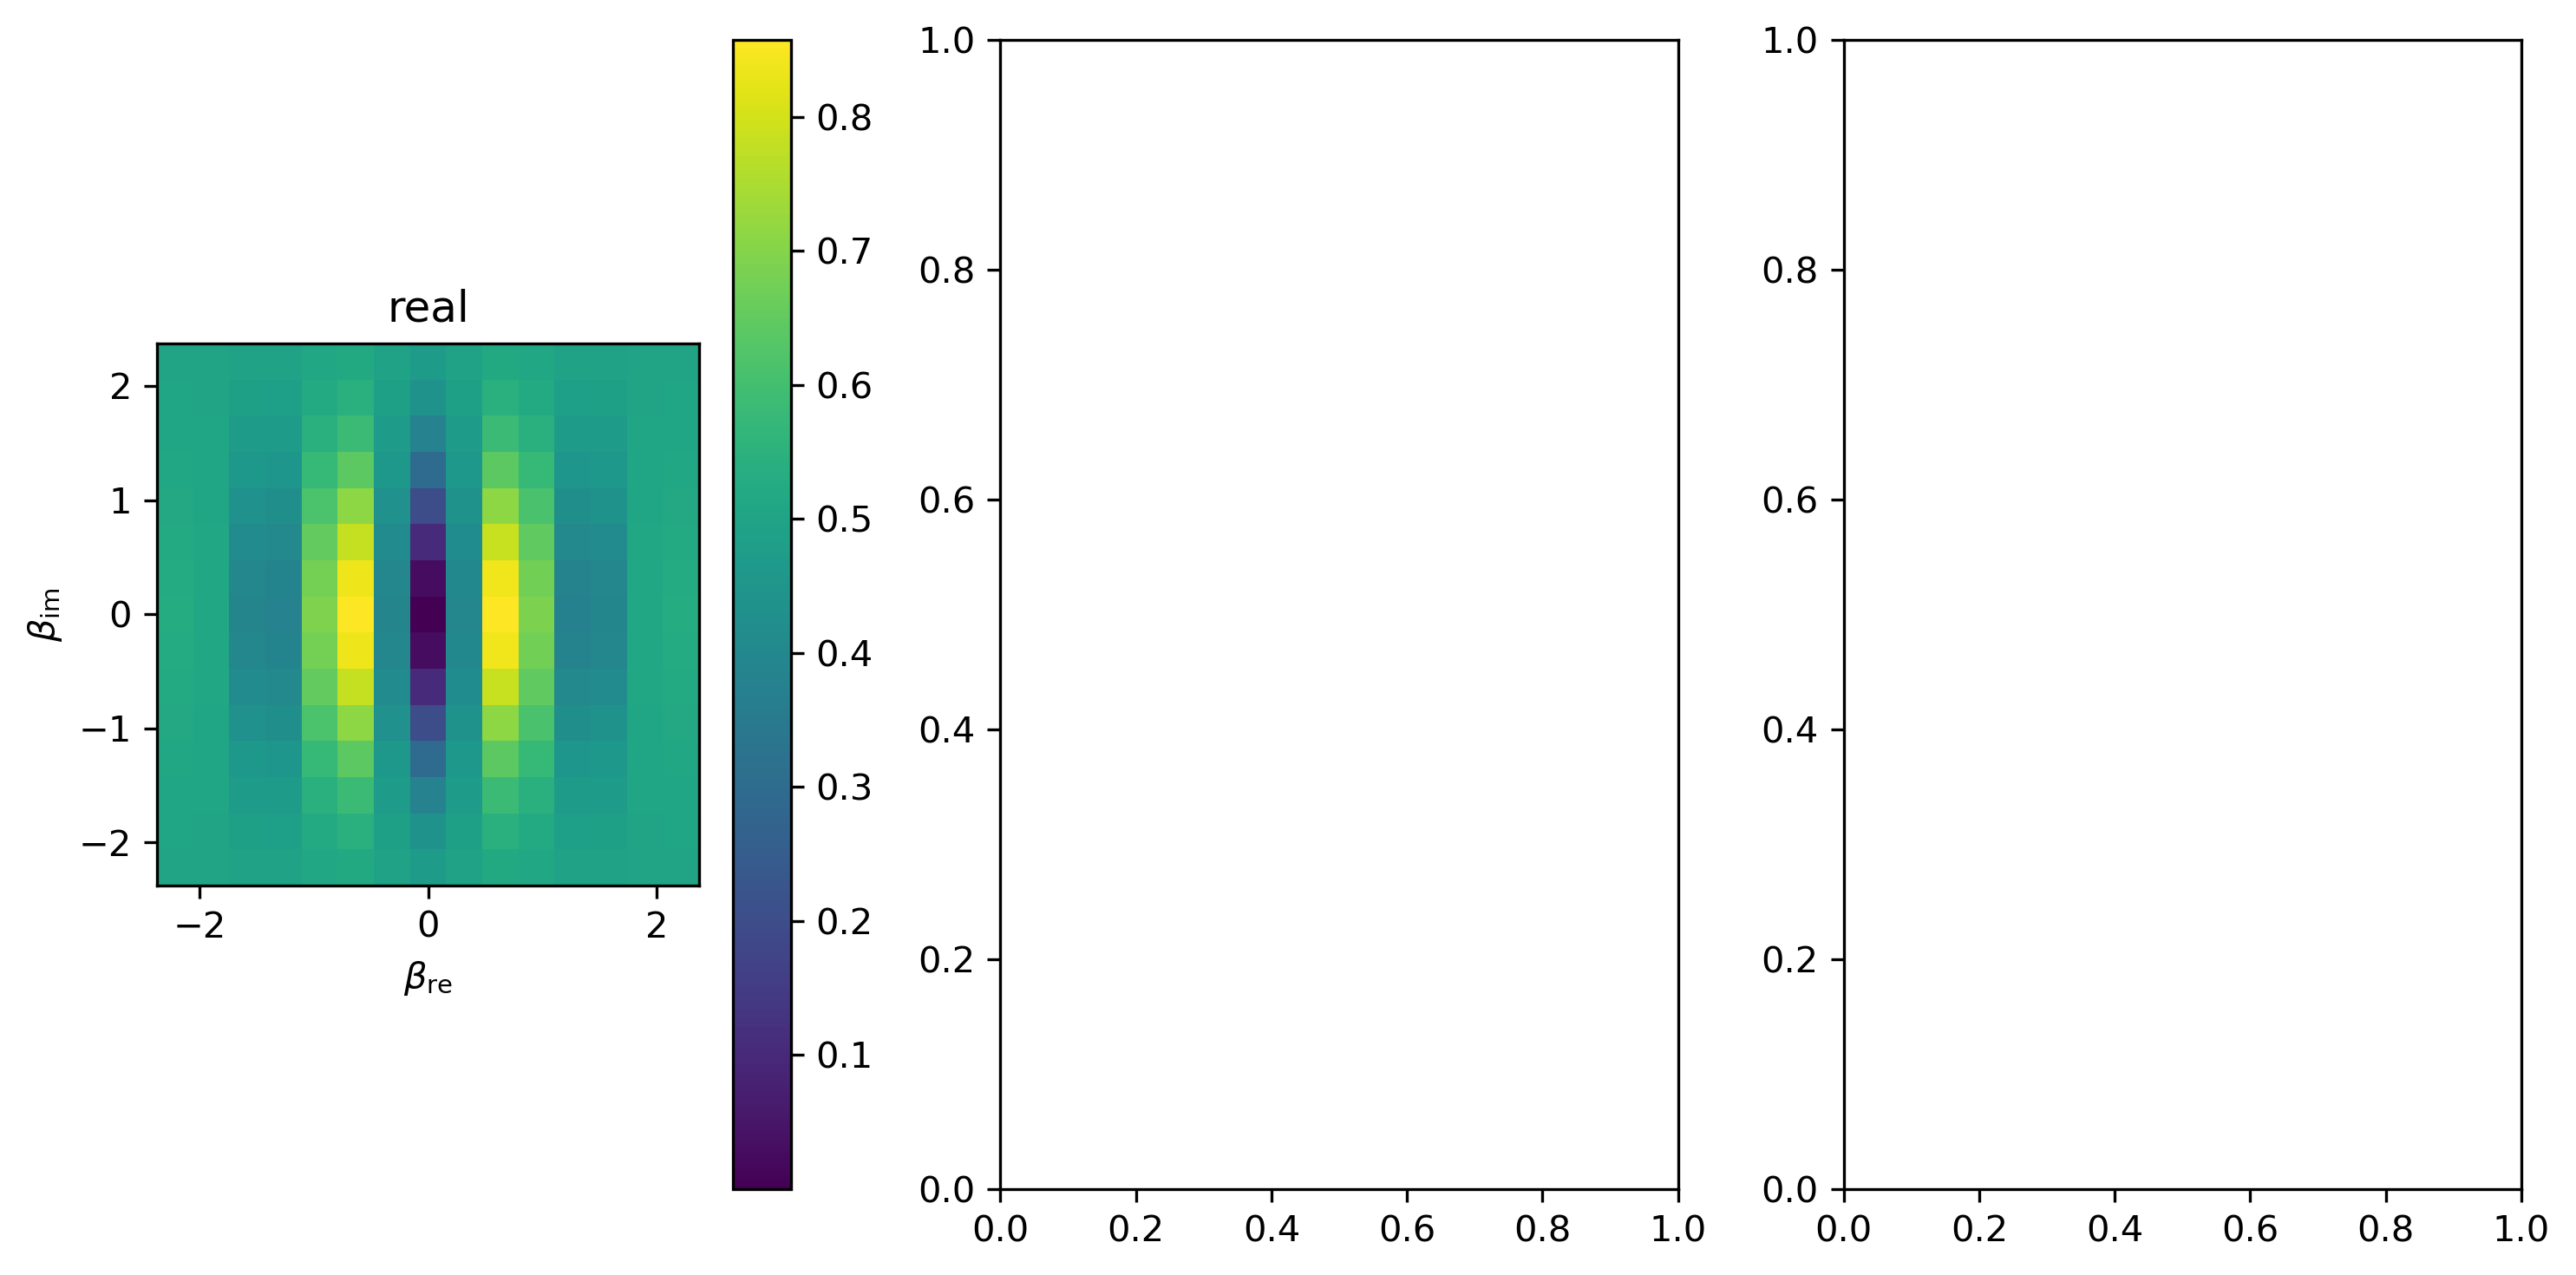

In [48]:
# Create a figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5),dpi=300)

# Plot the first image
im1 = ax1.imshow(wigner_beta_1, cmap='viridis', extent=[-beta_range,beta_range,-beta_range,beta_range])
ax1.title.set_text('real')
ax1.set_xlabel('$\\beta_{\\rm re}$')
ax1.set_ylabel('$\\beta_{\\rm im}$')
fig.colorbar(im1, ax=ax1)  # Add a colorbar to the first subplot

#Plot the second image
#im2 = ax2.imshow(np.abs(wigner_beta_2), cmap='viridis', extent=[-beta_range,beta_range,-beta_range,beta_range])
# ax2.title.set_text('imag')
# ax2.set_xlabel('$\\beta_{\\rm re}$')
# ax2.set_ylabel('$\\beta_{\\rm im}$')
# fig.colorbar(im2, ax=ax2)  # Add a colorbar to the second subplot

#Plot the second image
#im3 = ax3.imshow(np.abs(wigner_beta_1+1.0j*wigner_beta_2), cmap='viridis', extent=[-beta_range,beta_range,-beta_range,beta_range])
# ax3.title.set_text('total')
# ax3.set_xlabel('$\\beta_{\\rm re}$')
# ax3.set_ylabel('$\\beta_{\\rm im}$')
# fig.colorbar(im3, ax=ax3)  # Add a colorbar to the second subplot

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements

In [50]:
# do zero padding in FFT
def zero_pad(ratio:float, mat):
    pad=int(ratio*len(mat))

    new_len=len(mat)+pad+pad

    new_mat=np.zeros((new_len,new_len), dtype=mat.dtype)

    new_mat[pad:-pad,pad:-pad]=mat

    return new_mat

0.49877199350951806
-4.530009083217331


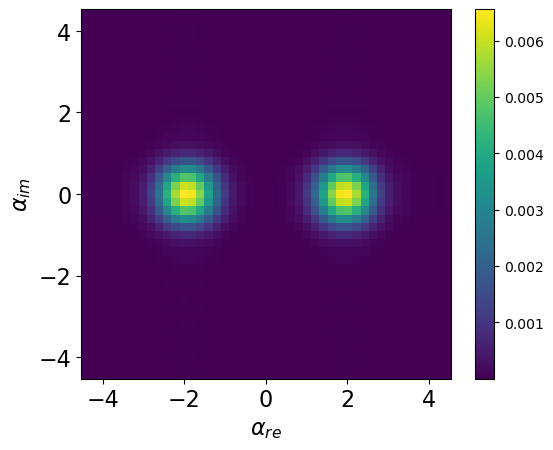

In [52]:
chi=wigner_beta_1*1#+wigner_beta_2*1.0j

#offset substruction
L=len(chi)
offset=(np.sum(chi)-np.sum(chi[L//6:L*5//6, L//6:L*5//6]))/(L*L-(L*5//6-L//6)**2)
print(offset)

chi_pad=np.pad(chi, pad_width=15, mode='constant', constant_values=0.5)-0.5

tmpwig=np.fft.ifft2(chi_pad)
wig=np.fft.fftshift(tmpwig)

beta=np.linspace(-beta_range, beta_range, len(chi_pad))
alpha=np.fft.fftshift(np.fft.fftfreq(len(beta), beta[1]-beta[0]))

print(alpha[0])
#
plt.imshow(np.abs(wig), extent=[alpha[0],alpha[-1],alpha[0],alpha[-1]])
plt.xlabel('$\\alpha_{re}$',fontsize=16)
plt.ylabel('$\\alpha_{im}$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.colorbar()


In [12]:
eta*Rabi_freq*50/2

0.5893627818134451